## View Model
### Imports

In [1]:
import sys
import os
from config import Config
sys.path.append(Config.root_path)

import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Load Model
from Python.data_processing.compare_predictions import load_model
from Python.model.segmentation_model import deeplabv3plus
# Load Dataset
from Python.data_processing.utils import get_png_paths_from_dir
from Python.data_processing.utils import load_weight_map
from Python.data_processing.data_generator import generate_image_dataset_from_files
# Get model performance metrics
from Python.data_processing.compare_predictions import show_predictions
from Python.data_processing.compare_predictions import create_confusion_matrix
from Python.data_processing.compare_predictions import plot_confusion_matrix
from Python.data_processing.utils import get_class_pixel_maps

2023-04-18 12:20:33.277780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 12:20:34.132053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-04-18 12:20:34.132246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-04-18 12:20:34.132256: W tens

### Load Model

In [2]:
class MyMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

model_num = str(13)
model_dir_path = os.path.join(Config.model_dir_path, model_num) 
model_path = os.path.join(model_dir_path, "model")
history_path = os.path.join(model_dir_path, "history.json")
model = load_model(model_path, compile=False)
IOU = MyMeanIoU(
    Config.output_channels,
    ignore_class=Config.background_label
)
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-7),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[IOU],
    weighted_metrics = ["accuracy"]
)

### Load Dataset

In [3]:
image_files = get_png_paths_from_dir(Config.image_path)
mask_files = get_png_paths_from_dir(Config.segmentation_path)

weight_map = load_weight_map(Config.weight_map_path)
weights = np.ones(Config.output_channels, dtype=np.float32)
weights[Config.background_label] = 0

dataset = generate_image_dataset_from_files(
    image_files, 
    mask_files, 
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    weights
)
with open(Config.partition_path, "r") as file:
    partition = json.load(file)
test_filenames = partition.get("test")[0]
test_image_paths = [
    os.path.join(Config.image_path, filename) for filename in test_filenames
]
test_mask_paths = [
    os.path.join(Config.segmentation_path, filename) for filename in test_filenames
]
test_dataset = generate_image_dataset_from_files(
    test_image_paths,
    test_mask_paths,
    Config.batch_size,
    tf.data.AUTOTUNE,
    100,
    weights
)

### Compare Image, Segmentation Mask and Prediction

2023-04-18 12:20:48.313547: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-18 12:20:48.313638: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-18 12:20:48.467075: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-18 12:20:48.467146: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/1 [==============================] - 4s 4s/step


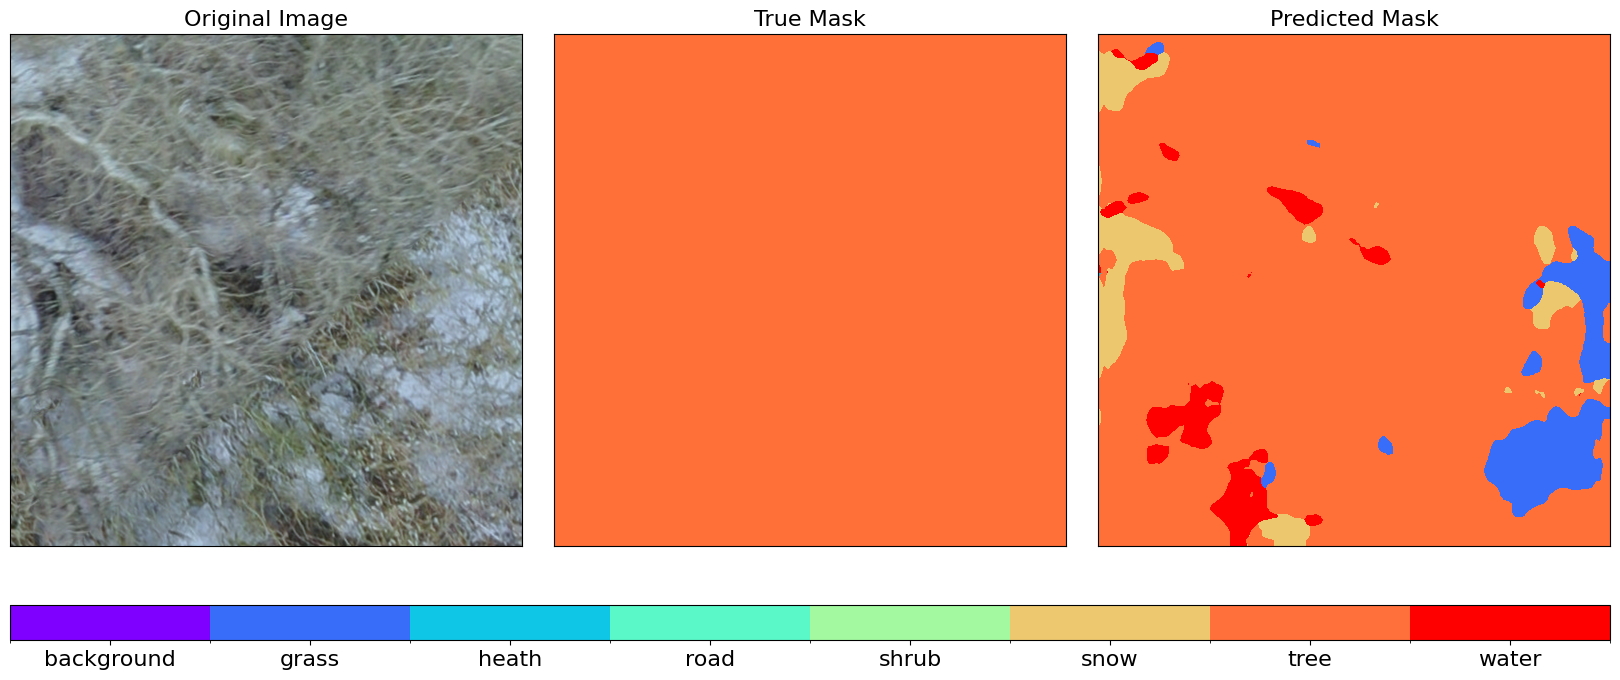

1/1 [==============================] - 0s 70ms/step


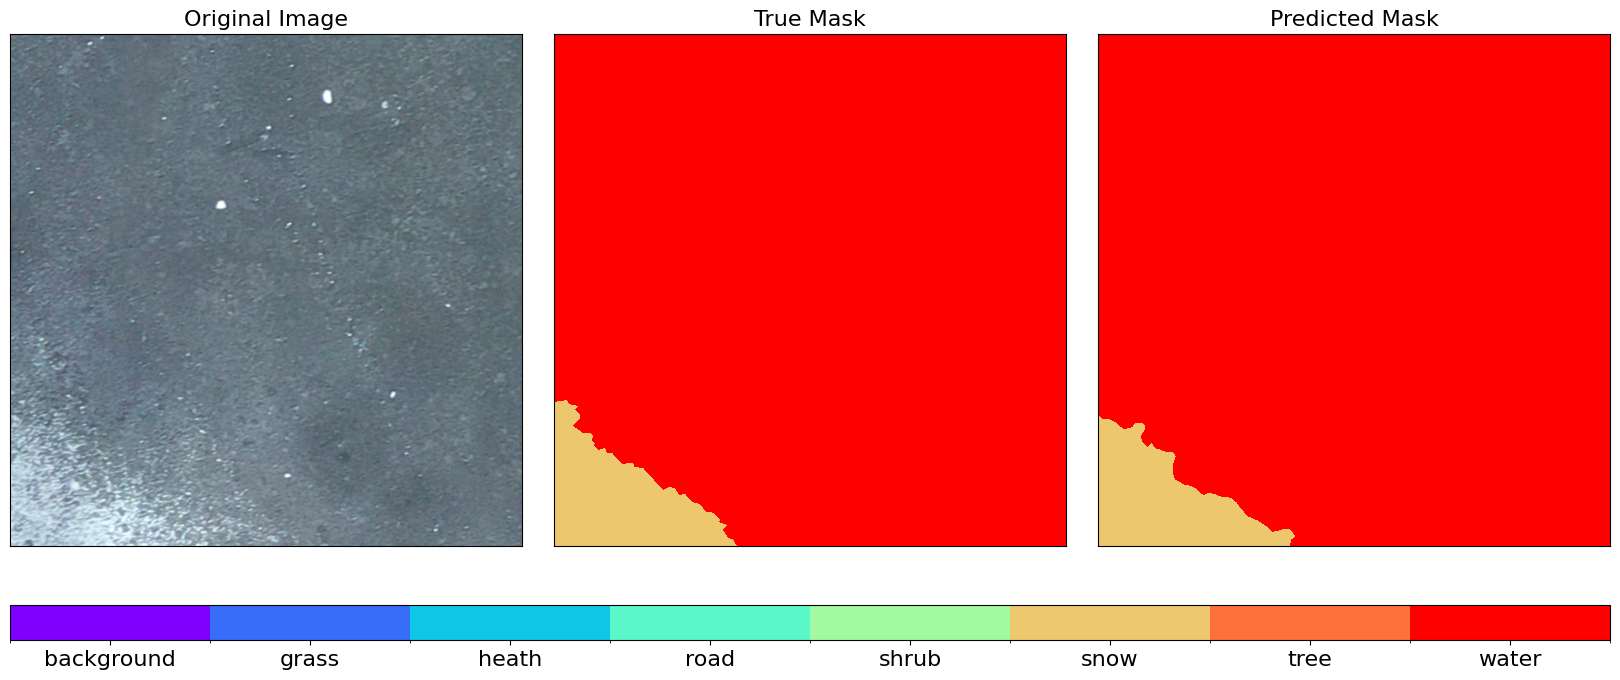

1/1 [==============================] - 0s 34ms/step


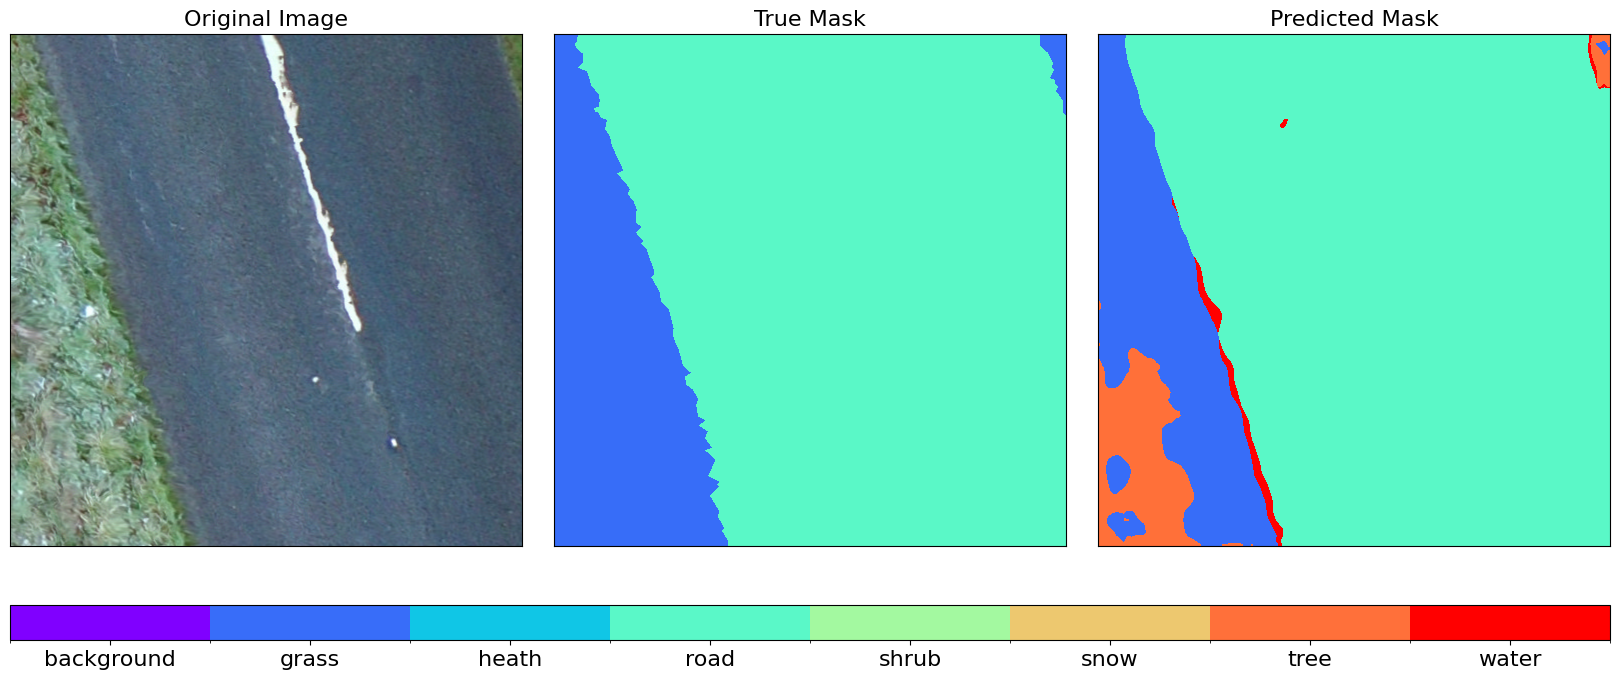

1/1 [==============================] - 0s 56ms/step


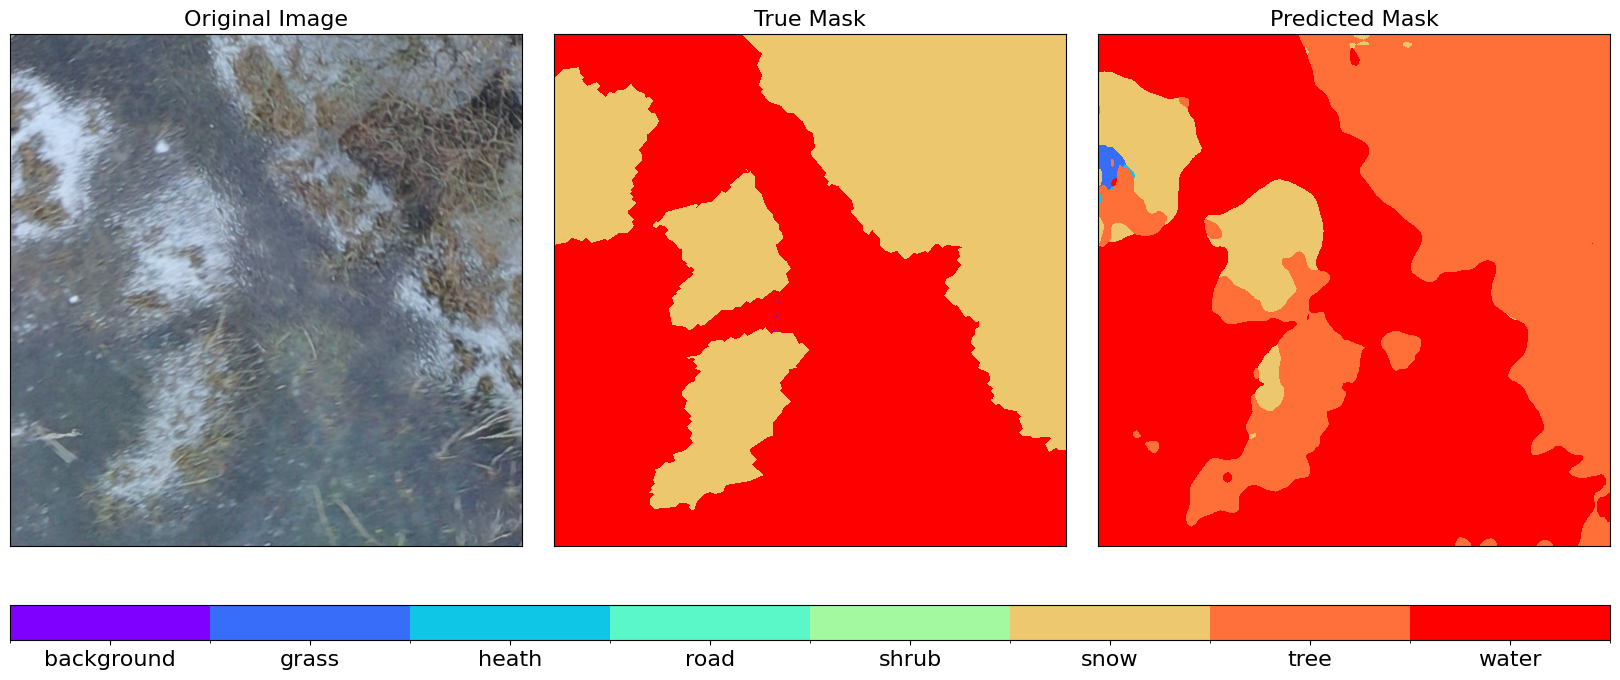

1/1 [==============================] - 0s 48ms/step


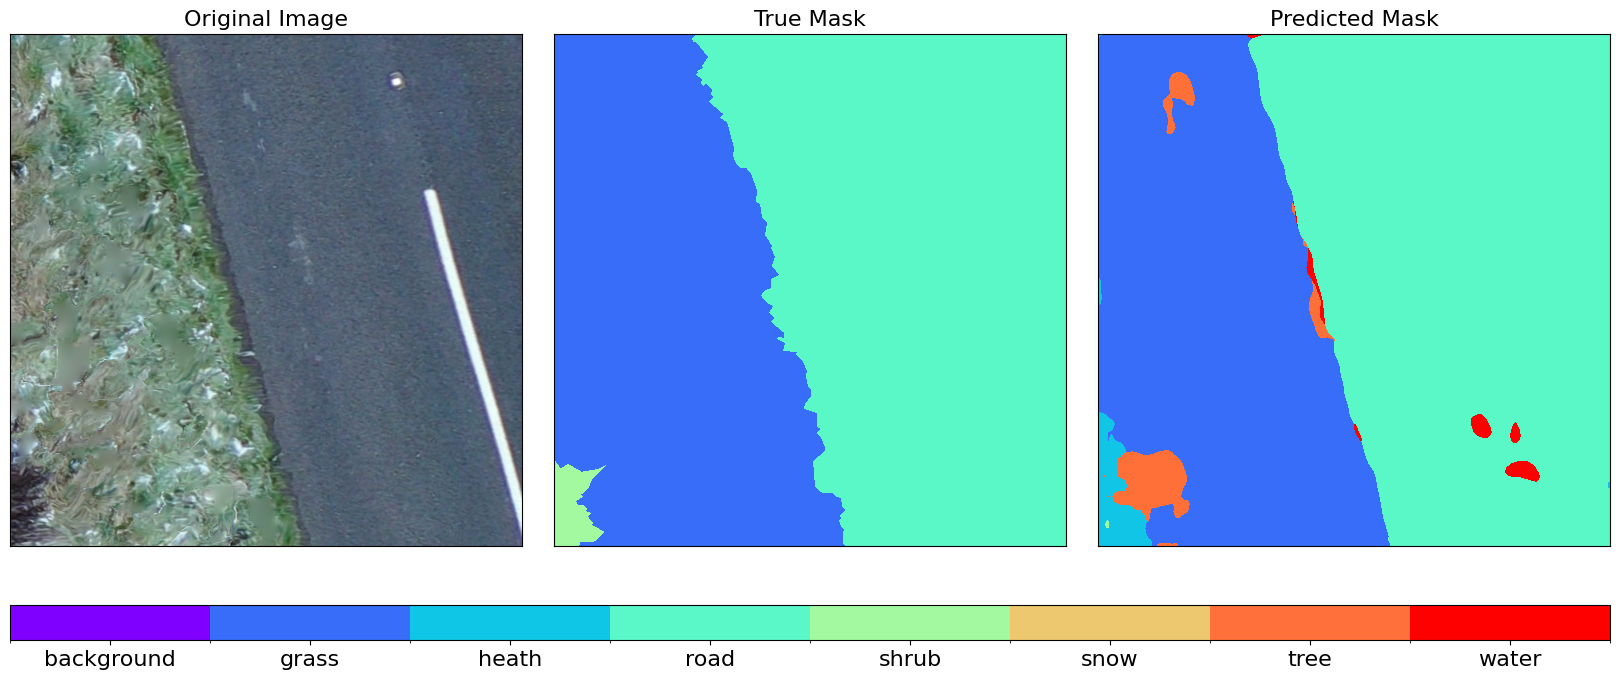

1/1 [==============================] - 0s 47ms/step


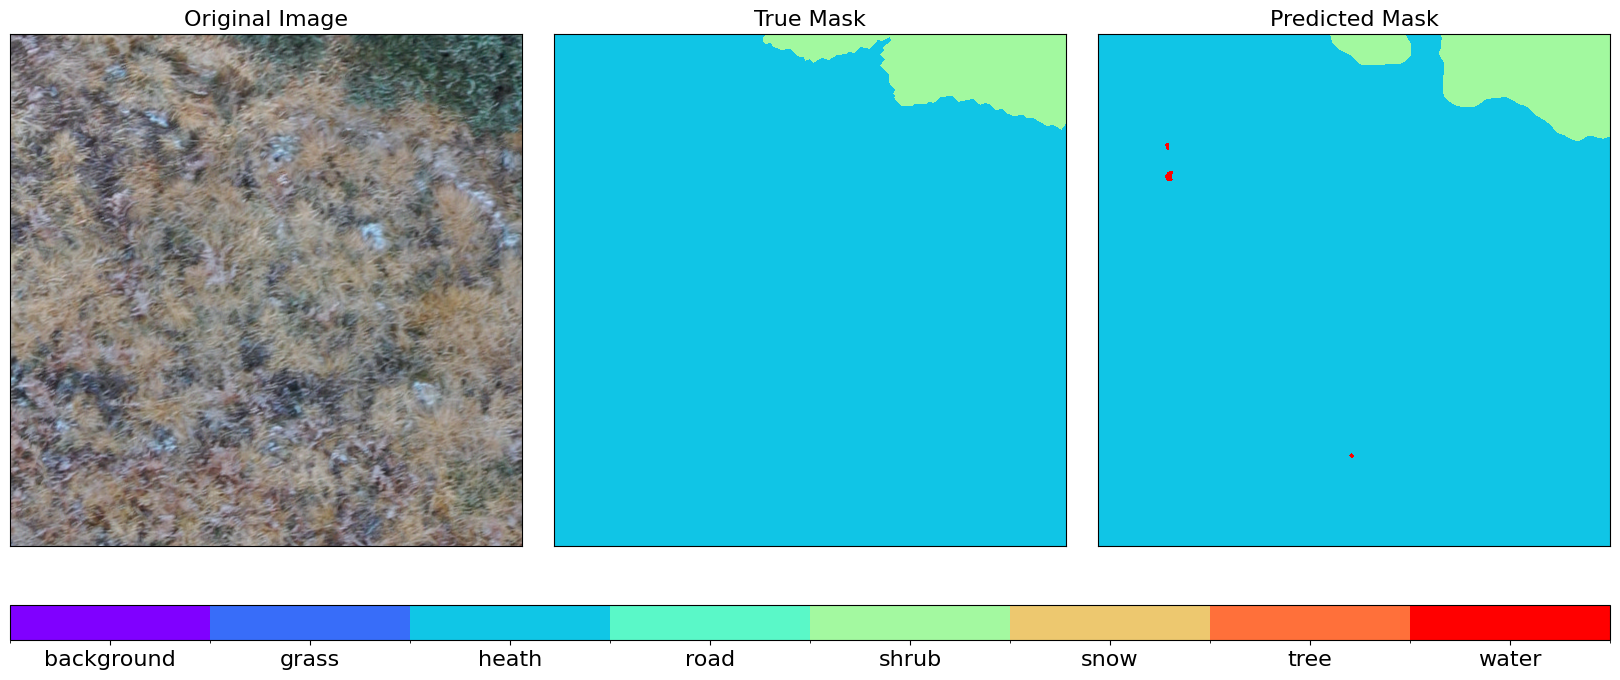

1/1 [==============================] - 0s 35ms/step


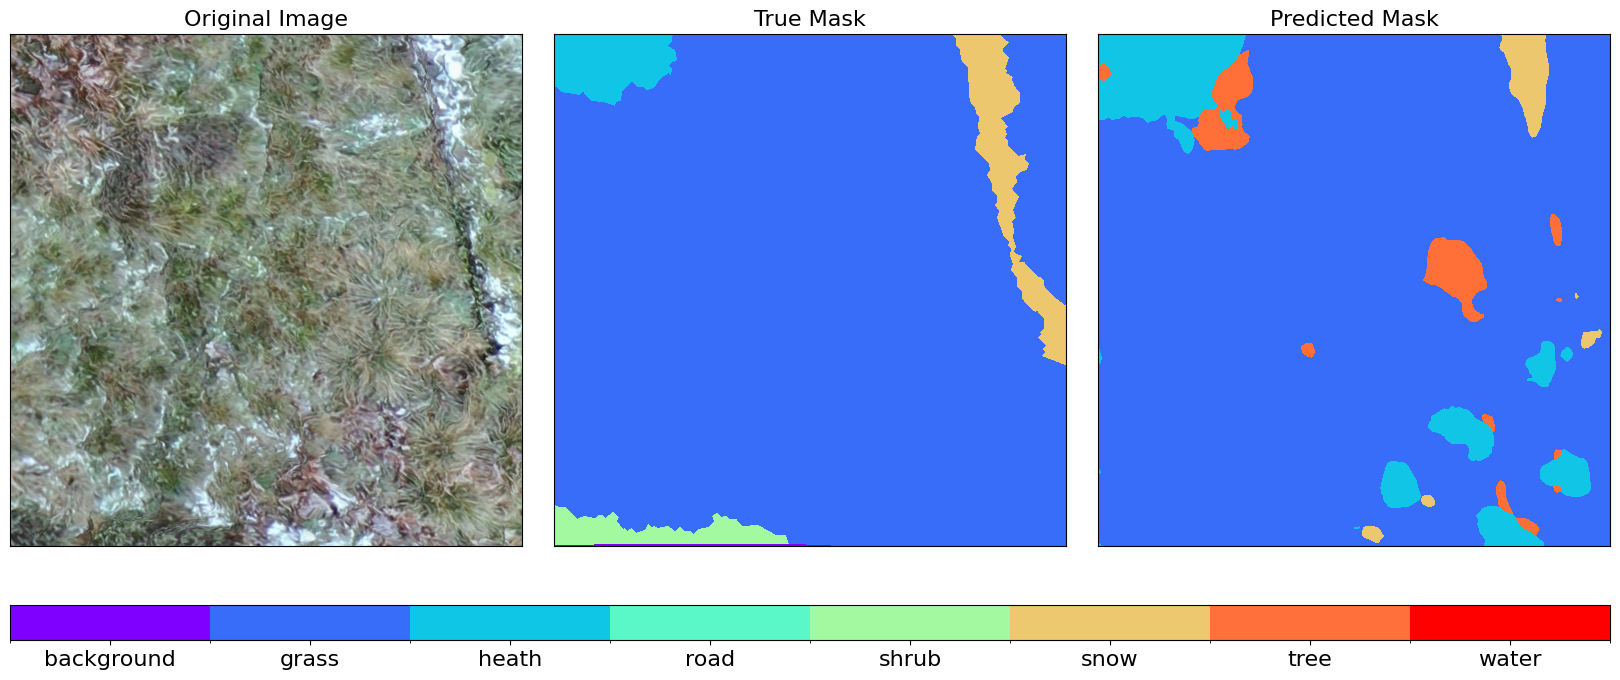

1/1 [==============================] - 0s 40ms/step


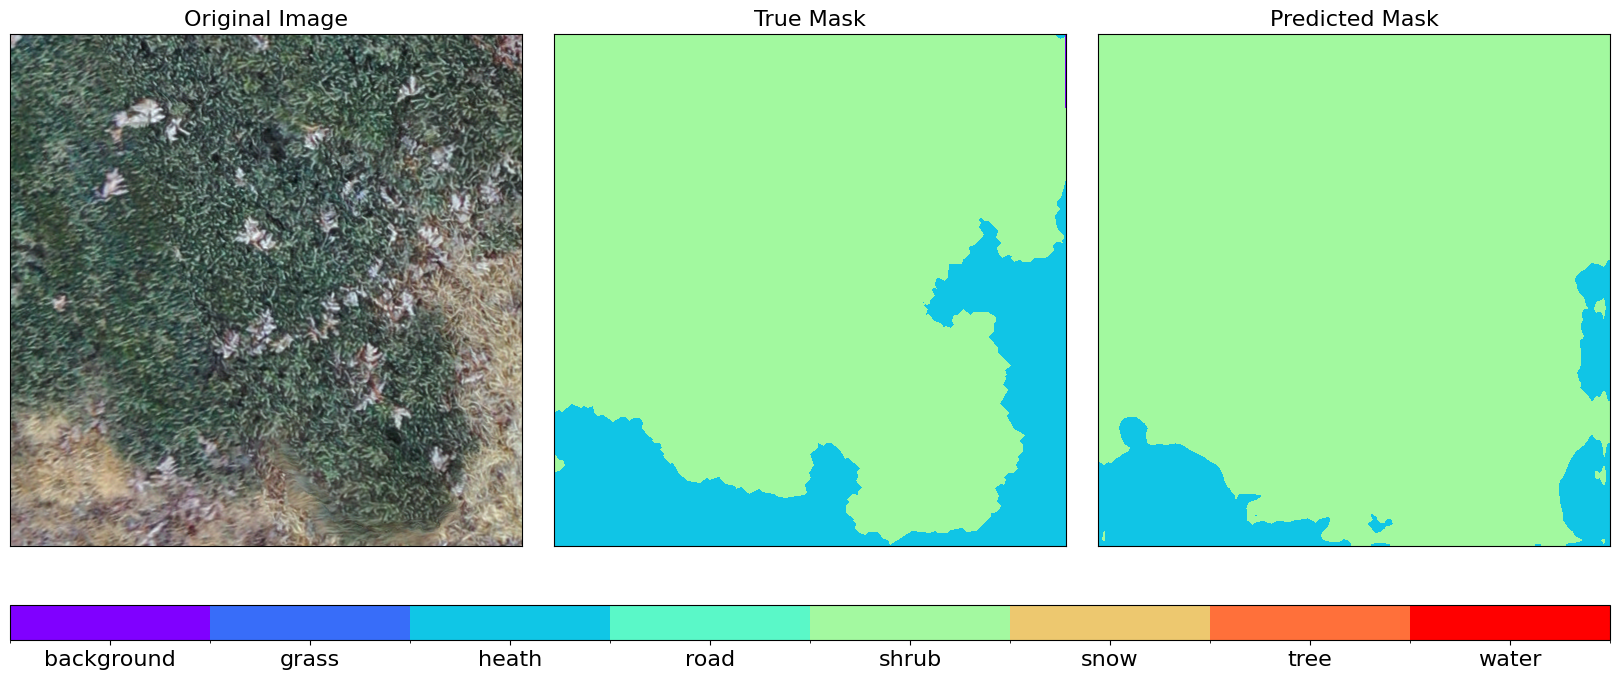

1/1 [==============================] - 0s 62ms/step


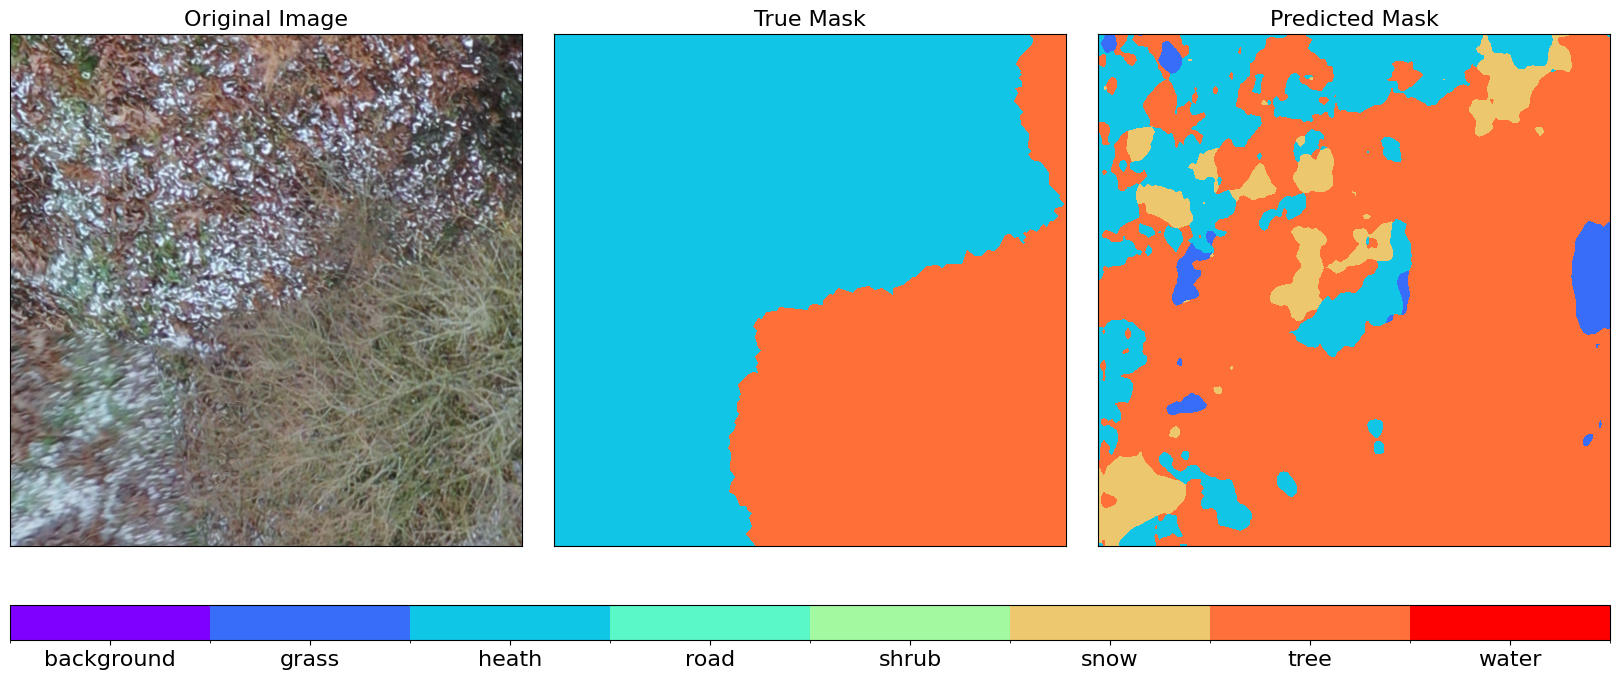

1/1 [==============================] - 0s 39ms/step


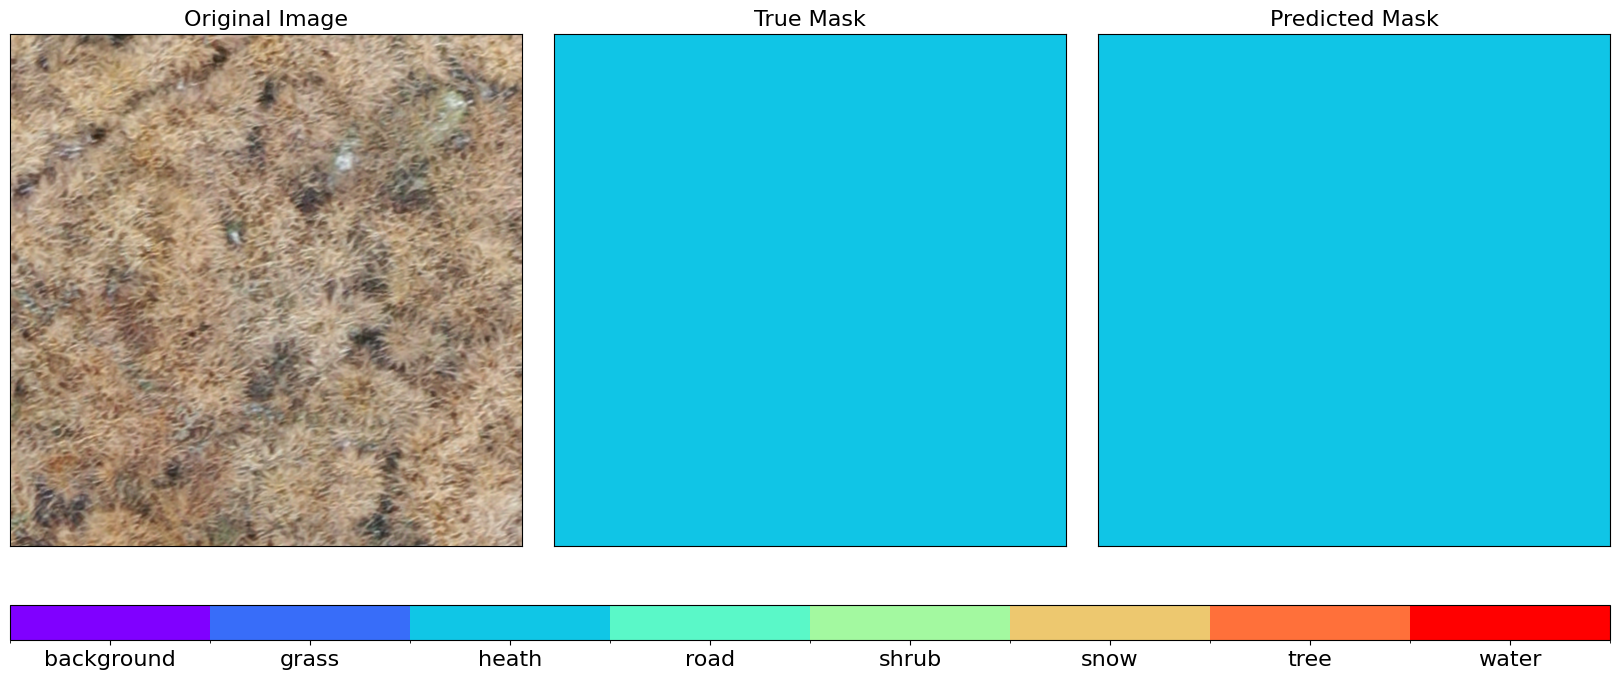

In [4]:
show_predictions(model, test_dataset, 10)

### Determine Model Performance Metrics

In [5]:
model.evaluate(dataset)
model.evaluate(test_dataset)

 73/127 [================>.............] - ETA: 6s - loss: 0.3301 - my_mean_io_u: 0.7566 - accuracy: 0.8875

### Create confusion matrix for test_dataset

1/1 [==============================] - 0s 37ms/step


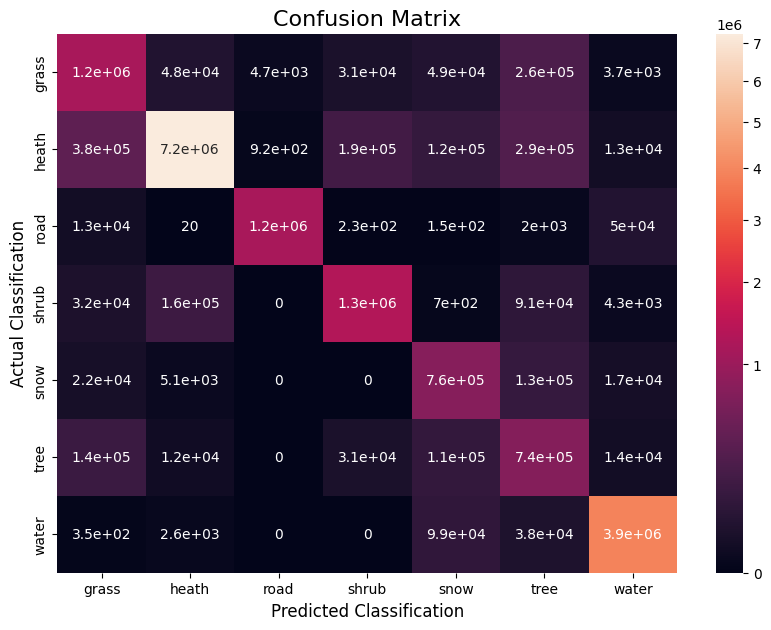

In [ ]:
confusion_matrix = create_confusion_matrix(
    model, 
    test_dataset, 
    Config.output_channels
)
confusion_matrix_no_background = confusion_matrix[1:, 1:]
labels = get_class_pixel_maps(Config.colour_map_path)[0].keys()
labels_no_background = list(labels)[1:]
plot_confusion_matrix(confusion_matrix_no_background, labels_no_background)

Other Metrics

In [ ]:
def Precision_Recall_F1(id, confusion_matrix):
    true_pos = confusion_matrix[id, id]
    predicted = np.sum(confusion_matrix[:,id])      # includes false positives
    actual = np.sum(confusion_matrix[id]) 

    precision = true_pos / predicted
    recall = true_pos / actual

    f1 = (2 * precision * recall) / (precision + recall)
    return precision, recall, f1


def total_predictions(confusion_matrix):
    total_predictions = np.sum(confusion_matrix, axis=-1)
    return total_predictions

def weighted_f1(confusion_matrix):
    n_classes = len(confusion_matrix)
    class_totals = total_predictions(confusion_matrix)
    f1_scores = np.zeros(n_classes, dtype=float)
    for i in range(n_classes):
        f1_scores[i] = Precision_Recall_F1(i, confusion_matrix)[2]
    f1_weighted = np.sum(class_totals * f1_scores / np.sum(class_totals))
    return f1_weighted


print("     Precision              Recall              F1")
for i in range(0,7):
    print(Precision_Recall_F1(i, confusion_matrix_no_background))

f1_weighted = weighted_f1(confusion_matrix_no_background)
print(f"Weighted F1: {f1_weighted}")

     Precision              Recall              F1
(0.6636853422543748, 0.7475609959154607, 0.703130647018856)
(0.9693999405520317, 0.8794793208923675, 0.9222529768912563)
(0.995182007839762, 0.9470422129399492, 0.9705155160759237)
(0.8386671687954746, 0.8183908621655716, 0.8284049617048349)
(0.6674505122075922, 0.8148334607204035, 0.7338148703684827)
(0.4779081326503545, 0.7033929945455855, 0.5691304694520349)
(0.9743442830085294, 0.9653989137796481, 0.9698509720475771)
Weighted F1: 0.8800178728586726


### Graph performance parameters from last training session

In [ ]:
history_path = r"/mnt/d/Liws/OneDrive - University of Bristol/Linux/CEZ_Mapping/Data/Models/13/history.json"
with open(history_path) as file:
    model_history = json.load(file)
loss = model_history.get("loss")
val_loss = model_history.get("val_loss")
x_vals = np.arange(len(loss))
plt.figure()
plt.plot(x_vals, loss, "r", label="Training accuracy")
plt.plot(x_vals, val_loss, "b", label="Validation accuracy")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 3])
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/Liws/OneDrive - University of Bristol/Linux/CEZ_Mapping/Data/Models/13/history.json'